In [49]:
import psi4
import numpy as np
from matplotlib import pyplot as plt
import scipy.linalg

In [50]:
# GETTING STUFF FROM PSI4

# Water. Look what you brought into my life.
r_h2o = 1.809
theta_h2o = 104.59

h2o = """
        O
        H 1 {0}
        H 1 {0} 2 {1}
        symmetry c1
        units bohr
""" .format(r_h2o, theta_h2o)

molecule = psi4.geometry(h2o)

options = {
    'basis' : 'cc-pVDZ',
    'reference' : 'uhf',
    'scf_type' : 'direct',
    'guess' : 'core',
    'guess_mix' : 'true',
    'e_convergence' : 1e-7
} 

psi4.set_options(options)

wavefunction = psi4.core.Wavefunction.build(molecule,
                        psi4.core.get_global_option('basis'))

mints = psi4.core.MintsHelper(wavefunction.basisset())

# Hamiltonian operator
T = np.asarray(mints.ao_kinetic())
V = np.asarray(mints.ao_potential())
H = T + V

# Other things
W = np.asarray(mints.ao_eri())
S = np.asarray(mints.ao_overlap())

# Some numbers
number_of_orbitals = wavefunction.nso()
number_of_occupied_ups   = wavefunction.nalpha()
number_of_occupied_downs = wavefunction.nbeta()

# Nuclear repulsion
E_nuc = molecule.nuclear_repulsion_energy()

In [51]:
e_init, U_init = scipy.linalg.eigh(H, S)

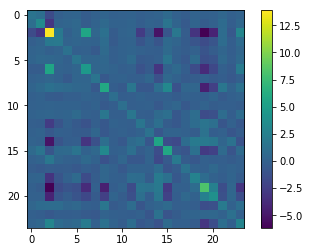

In [52]:
plt.figure()
plt.imshow(np.linalg.multi_dot([U_init, S, np.transpose(U_init)]))
plt.colorbar()
plt.show()

In [53]:
print("Number of occupied ups:   ", number_of_occupied_ups)
print("Number of occupied downs: ", number_of_occupied_downs)
print("Total orbitals:           ", number_of_orbitals)


Number of occupied ups:    5
Number of occupied downs:  5
Total orbitals:            24


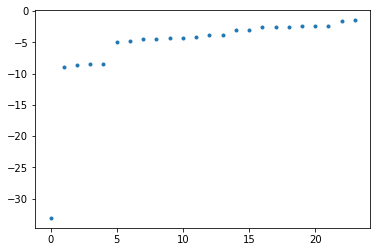

In [54]:
# What can we conclude from this? 
# The first five guys are occupied states.
plt.plot(e_init, '.')
plt.show()

In [55]:
# Constructing density matrix
U_up   = np.matrix(U_init[:, 0:number_of_occupied_ups])
D_up   = np.dot(U_up, U_up.H) 
U_down = np.matrix(U_init[:, 0:number_of_occupied_downs])
D_down = np.dot(U_down, U_down.H)

In [56]:
# Now the U_up and U_down are equal, so we scramble them
X = np.random.rand(*D_up.shape)
X = X + np.transpose(X)
D_up = D_up + 0.001*X

X = np.random.rand(*D_down.shape)
X = X + np.transpose(X)
D_down = D_down + 0.001*X

In [57]:
# Now to construct the Fock matrix
J = np.einsum('pqrs, sr->pq', W, D_up + D_down)
K_up   = np.einsum('psrq, sr->pq', W, D_up)
K_down = np.einsum('psrq, sr->pq', W, D_down)
F_up   = H + J - K_up
F_down = H + J - K_down

In [58]:
# Iterating.
for i in range(15):
    E_up,   U_up   = scipy.linalg.eigh(F_up,   S)
    E_down, U_down = scipy.linalg.eigh(F_down, S)
    
    U_up   = np.matrix(U_up[:, 0:number_of_occupied_ups])
    D_up   = np.dot(U_up, U_up.H) 
    U_down = np.matrix(U_down[:, 0:number_of_occupied_downs])
    D_down = np.dot(U_down, U_down.H)
    
    J = np.einsum('pqrs, sr->pq', W, D_up + D_down)
    K_up   = np.einsum('psrq, sr->pq', W, D_up)
    K_down = np.einsum('psrq, sr->pq', W, D_down)
    F_up   = H + J - K_up
    F_down = H + J - K_down
    
    E_up_occ   = np.sum(E_up[0:number_of_occupied_ups])
    E_down_occ = np.sum(E_down[0:number_of_occupied_downs])
    
    print("Energies: E_up: {:4f} E_down {:4f}".format(E_up_occ, E_down_occ))

print(E_up[0:number_of_occupied_ups])
print(E_down[0:number_of_occupied_downs])


Energies: E_up: -15.715721 E_down -15.721266
Energies: E_up: -33.604839 E_down -33.604919
Energies: E_up: -18.249864 E_down -18.249877
Energies: E_up: -29.960346 E_down -29.960424
Energies: E_up: -19.725167 E_down -19.725169
Energies: E_up: -26.206718 E_down -26.206704
Energies: E_up: -22.200605 E_down -22.200604
Energies: E_up: -24.520265 E_down -24.520263
Energies: E_up: -23.150835 E_down -23.150835
Energies: E_up: -23.936216 E_down -23.936215
Energies: E_up: -23.480043 E_down -23.480043
Energies: E_up: -23.742187 E_down -23.742187
Energies: E_up: -23.590673 E_down -23.590673
Energies: E_up: -23.677896 E_down -23.677896
Energies: E_up: -23.627564 E_down -23.627564
[-20.5420732   -1.33393394  -0.69738853  -0.5638261   -0.49034262]
[-20.54207319  -1.33393391  -0.69738852  -0.56382608  -0.4903426 ]


In [59]:
# Those last lines are the energy of the occupied states
print("Energy of all occupied: ", E_up_occ + E_down_occ)

Energy of all occupied:  -47.2551286815


In [60]:
SCF_energy = psi4.energy('scf')
print(SCF_energy)

-76.02679362282558


In [69]:
# Calculating energy
J_up   = np.einsum('pqrs, sr->pq', W, D_up)
J_down = np.einsum('pqrs, sr->pq', W, D_down)
K_up   = np.einsum('psrq, sr->pq', W, D_up)
K_down = np.einsum('psrq, sr->pq', W, D_down)

F_up   = H + J - K_up
F_down = H + J - K_down

# Fock energy
energy  =      np.einsum('pq, qp->', F_up,    D_up)\
             + np.einsum('pq, qp->', F_down, D_down)

# Hartree energy
energy -= 0.5*(np.einsum('pq, qp->', J_up,    D_up)\
             + np.einsum('pq, qp->', J_up,    D_down)\
             + np.einsum('pq, qp->', J_down,  D_up)\
             + np.einsum('pq, qp->', J_up,    D_down))

# Exchange energy
energy += 0.5*(np.einsum('pq, qp->', K_up,    D_up)\
             + np.einsum('pq, qp->', K_down,  D_down))

# Nuclear energy
energy += E_nuc

print(energy)

-76.0267846788
